# Fang & Oosterle (2008) : A novel pricing method for european options based on Fourier-Cosine series expansions (Part I/II) and Heston (1993)

The goal of the Heston Model is the pricing of options based on the Heston stochastic volatility model (Heston, 1993). To solve the Heston Model, we use Fang and Osterle's (2008) COS-FFT transformation. With the COS-FFT, we are able to calculate the p.d.f. of a characteristic function on a general interval. The density of the probabilistic function of the Heston model is  used to calculate option prices.

In [2]:
#TODO:
# implement (22) & (23)  which are needed in (29) DONE

# implement pricing formula (30), and all needed components

# implement Heston model

# replicate numerical results (5.)

Formulas and text are from Fang & Oosterle 2008 paper. Chapter and equation numbers also correspond)

In [2]:
%matplotlib inline

import cmath   # c stands for complex (to handle complex numbers)
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_fn

In [33]:
#Initializing the necessary parameters
######################################

#Option parameters (Feng & Osterle (2008), p. 13)
style = 1            # if style=1 then call, else put
U = 0.16             # variance at t=0
r = 0.1              # annual interest rate
K = np.arange(10,121) # strike price, ndarray
S = 100              # initial price
tau = 1              # years to maturity

#Heston parameters
lam = 2              # mean reversion
eta = 0.4            # volatility of volatility
rho = -0.5           # correlation coefficient Brownian Motion
mu = r               # drift of Brownian Motion (here interest rate)
uBar = 0.2           # mean level of variance
x = np.log(S/K)      #ndarray of length K
#print(len(x))
#print(len(K))

In [34]:
#Setting up the COS_FFT
#######################
# Set up
a = -5 * np.sqrt(uBar + uBar * eta) #5 times the std as interval boundaries
b = 5 * np.sqrt(uBar + uBar * eta)
N = 50
k = np.arange(0,N)  #ndarray of length N
#print(k)
ome = k * np.pi / (b-a)   #ndarray of length N
#print(ome)     

In [35]:
# equation (22)
def chi_cosine_series_coeff(k, a, b, c, d):
    """
    Helper Function (22) in the F&O paper
    Args:
        k : coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral 
        c : 0
        d : a or b
    Returns:
        chi_k : ndarray with N floats, a cosine series coefficient ndarray
    """
    
    
    multiplier = 1 / (1 + (k* np.pi / (a - b))**2 )
    
    cos1 = np.cos( k * np.pi * ( (d-a)/(b-a) ) ) * np.exp(d)
    cos2 = np.cos( k * np.pi * ( (c-a)/(b-a) ) ) * np.exp(c)
    
    sin1 = (k * np.pi)/(b-a) * np.sin( k * np.pi * ( (d-a)/(b-a) ) ) * np.exp(d)
    sin2 = (k * np.pi)/(b-a) * np.sin( k * np.pi * ( (c-a)/(b-a) ) ) * np.exp(c)
    
    in_brakets = cos1 - cos2 + sin1 - sin2

    return multiplier * in_brakets
    
# equation (23)
def psi_cosine_series_coeff(k, a, b, c, d):
    """
    Helper Function (23) in the F&O paper
    Args:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral
        c : 0
        d : a oder b
        
    Returns:
        psi_k : ndarray with N floats, a cosine series coefficient ndarray
    """
    pi = np.pi
    
    sin1 = np.sin(k * pi * (d-a)/(b-a))
    sin2 = np.sin(k * pi * (c-a)/(b-a))
    in_brakets = sin1 - sin2
        
    y = in_brakets * (b-a) / (k * pi)
    y[0] = (d-c)
    
    return y
        

In [37]:
def UK(k, a, b, style):
    """
    Helper function for COS_FFT, (Fang & Osterle (2008), p. 6-7. )
    Equation (29) in F&O paper. Calculates U_k.
    Uses formula (22) and (23)
    In:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a : float, left border of the trucated integral
        b : float, right border of the truncated integral
        style: bool, indicating whether the option is a call
    Returns:
        U:        ndarray of N floats, function value of UK
    """    
    # if the option is a call
    if style:
        chi_k = chi_cosine_series_coeff(k, a, b, 0, b) 
        psi_k = psi_cosine_series_coeff(k, a, b, 0, b)

        return (2 / (b - a)) * (chi_k - psi_k)
        
    # if the option is a put
    else:
        chi_k = chi_cosine_series_coeff(k, a, b, a, 0) 
        psi_k = psi_cosine_series_coeff(k, a, b, a, 0)
        
        return (2 / (b - a)) * (-chi_k + psi_k)

In [38]:
def char_fun_hes(ome, U, lam, eta, mu, rho, uBar, tau):
                  
    '''
    Characteristic function of Heston Model based on Fang & Osterle (2008), p. 8.
    
    ome = ndarray of length N
    U = variance at t=0
    lam = mean reversion
    eta = volatility of volatility
    mu = drift of Brownian Motion (here interest rate)
    rho = correlation coefficient Brownian Motion
    uBar = mean level of variance
    tau = years to maturity
    
    Returns ndarray of N floats
    '''
    D = (( lam - 1j * rho * ome * eta ) ** 2 + ( ome ** 2 + ome * 1j ) * eta ** 2) ** (0.5)
    G = (lam - 1j * rho * ome * eta - D) / (lam - 1j * rho * ome * eta + D)
    
    phiHes = (np.exp(1j * ome * mu * tau + (U / eta ** 2) * ((1 - np.exp(-D * tau)) / 
            (1 - G * np.exp(-D * tau))) * (lam - 1j * rho * ome * eta - D)) * 
            np.exp(((lam * uBar)/eta ** 2) * (tau * (lam - 1j * rho * ome *eta -D) - 
            2 * np.log((1-G * np.exp(-D * tau))/(1-G)))))
    
    return phiHes

In [39]:
#Setting up the COS_FFT
#######################
# Output
OptPri = np.zeros(len(K))
weights = np.ones(N)
weights[0] = 0.5 # setting first weight to half

for s in range(0, len(K)):
    OptPri[s] = (K[s] * np.exp(-r * tau) * np.real(sum(weights * 
                (char_fun_hes(ome, U, lam, eta, mu, rho, uBar, tau) *
                 np.exp (1j * ome * (x[s] -a)) * UK(k, a, b, style)))))   #ndarray of option prices of length K

#print(len(OptPri))

C:\Users\corin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


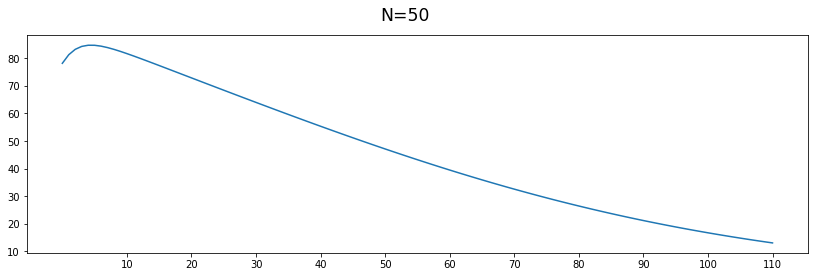

In [40]:
#plotting the output
####################
fig = plt.figure(figsize=(14,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("N=50", fontsize="xx-large")

plt.xticks(range(10, 121, 10))
plt.plot(OptPri);
plt.show()
#for values,j in zip(all_values[:5], range(1, 6)):
#    plt.subplot(1, 5, j)
#    plt.plot(*values);

## 3. Pricing European Options

COS formula for general underlying processes:
<img src="figures/f_19.png" width="680">

### 3.1. Coeﬃcients V k for Plain Vanilla Options
Before we can use (19) for pricing options, the payoﬀ series coeﬃcients, $V_k$ , have to be recovered. We can ﬁnd analytic solutions for $V_k$ for several contracts (Fang & Ooesterle, 2008)

Both the cosine series coeﬃcients, $\chi_k$ , of $g(y) = e^y$ on $[c,\ d] ⊂ [a,\ b]$ and 

the cosine series coeﬃcients, $\psi_k$, of $g(y) = 1$ on $[c,\ d] ⊂ [a,\ b]$, are known analytically

<img src="figures/f_22.png" width="480">

<img src="figures/f_23.png" width="480">

In [19]:
# equation (22)
def chi_cosine_series_coeff(k, a_param, b_param, c_param, d_param):
    """
    Function (22) in the F&O paper
    Args:
        k : coeﬃcients of the summand (runs from 0 to N-1)
        a_param : float, left border of the trucated integral
        b_param : float, right border of the truncated integral
        c_param : 
        d_param : 
        
    Returns:
        chi_k : float, a cosine series coefficient
    """

    pi = cmath.pi
    
    a = a_param
    b = b_param
    c = c_param
    d = d_param
    
    multiplier = 1 / (1 + (k*pi/(a - b))**2 )
    
    cos1 = cmath.cos( k*pi*( (d-a)/(b-a) ) ) * cmath.exp(d)
    cos2 = cmath.cos( k*pi*( (c-a)/(b-a) ) ) * cmath.exp(c)
    
    sin1 = (k*pi)/(b-a) * cmath.sin( k*pi*( (d-a)/(b-a) ) ) * cmath.exp(d)
    sin2 = (k*pi)/(b-a) * cmath.sin( k*pi*( (c-a)/(b-a) ) ) * cmath.exp(c)
    
    in_brakets = cos1 - cos2 + sin1 - sin2
    
    return multiplier * in_brakets
    
# equation (23)
def psi_cosine_series_coeff(k, a_param, b_param, c_param, d_param):
    """
    Function (23) in the F&O paper
    Args:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a_param : float, left border of the trucated integral
        b_param : float, right border of the truncated integral
        c_param : 
        d_param : 
        
    Returns:
        psi_k : float, a cosine series coefficient
    """
    pi = cmath.pi
    
    a = a_param
    b = b_param
    c = c_param
    d = d_param
    
    if k == 0:
        return d_param - c_param
    
    else:
        sin1 = cmath.sin(k*pi*(d-a)/(b-a))
        sin2 = cmath.sin(k*pi*(c-a)/(b-a))
        in_brakets = sin1 - sin2
        
        return in_brakets * (b-a) / (k*pi)

### 3.3. Formula for Lévy Processes and the Heston Model

__Lévy Processes__
<img src="figures/f_27_30.png" width="480">

For the CGMY/KoBol model, which encompasses the __Geometric Brownian Motion (GBM)__ and __Variance Gamma (VG)__ models, the characteristic function of the log-asset price is of the form:

<img src="figures/f_31.png" width="480">

In [34]:
def char_fun_levy(omega, r_param, q_param, sigma_param,
                  Y_param, C_param, G_param, M_param, T_param):
    """
    Characteristic function of the log-asset price according to a lévy process
    """
    r = r_param
    q = q_param
    sigma = sigma_param
    Y = Y_param
    C = C_param
    G = G_param
    M = M_param
    delta_t = T_param

    exp1 = cmath.exp(1j*omega*(r-q)*delta_t - 0.5* omega**2 * sigma**2 * delta_t)
    
    multip1 = delta_t*C*gamma_fn(-Y)
    multip2 = (M - 1j*omega)- M**Y + (G+1j*omega)**Y - G**Y
    exp2 = cmath.exp(multip1 * multip2)
    
    return exp1 * exp2

In [35]:
def U_cosine_coeff(k, a_param, b_param, call):
    """
    Equation (29) in F&O paper. Calculates U_k.
    In:
        k : int, coeﬃcients of the summand (runs from 0 to N-1)
        a_param : float, left border of the trucated integral
        b_param : float, right border of the truncated integral
        call: bool, indicating whether the option is a call
    Returns:
        float        float
    """    
    # if the option is a call
    if call:
        chi_k = chi_cosine_series_coeff(k, a_param, b_param, 0, b_param) 
        psi_k = psi_cosine_series_coeff(k, a_param, b_param, 0, b_param)

        return (2 / (b_param - a_param)) * (chi_k - psi_k)
        
    # if the option is a put
    else:
        chi_k = chi_cosine_series_coeff(k, a_param, b_param, a_param, 0) 
        psi_k = psi_cosine_series_coeff(k, a_param, b_param, a_param, 0)
        
        return (2 / (b_param - a_param)) * (-chi_k + psi_k)

Note SWS: We can define $F_k$ analoguous to the density case, so that we only need to run it $N$ times instead for every x. Thus,
$$
F_k = \phi\left(\frac{k\pi}{b-a}\right) \ U_k    \qquad with \qquad \phi : some\ characteristic \ function
$$

In [22]:
def get_Fk_values(a_param, b_param, char_fun, N, call_flag):
    """
    We only want to do this once and not for each x
    Args:
        a : float, left border of the trucated integral, e.g. mean-6*std
        b : float, right border of the truncated integral, e.g. mean+6*std
        char_fun : a characteristic function, taking 1 argument (\omega)
        N: int, should be between 50 and 500
        call : bool 
    Returns:
       np.array of shape (N,) containing the values computed by Fk for each k 
    """
    # This is a numpy placeholder for our values obtained by Fk
    values_Fk = np.zeros(N)
    
    # here we fill our placeholder with the correct values of Fk for each k
    for k in range(N):
        
        U_k = U_cosine_coeff(k, a_param, b_param, call=call_flag) 
        
        inside_omega = (k*cmath.pi) / (b_param-a_param)
        
        values_Fk[k] = char_fun(inside_omega) * U_k
        
    return values_Fk

In [ ]:
def pricing(x):
    """
    Equation (30) in F&O paper.
    """

__Heston Model__

In the Heston model, the volatility, denoted by $\sqrt{u_t}$, is modeled by a stochastic diﬀerential equation:
<img src="figures/f_32.png" width="480">
<img src="figures/f_33_34.png" width="480">
<img src="figures/f_33b.png" width="480">

## 5. Numerical Results
### 5.1. Truncation Range for COS Method